In [ ]:
'''
MODELLING - DEEP LEARNING - 1
'''
import os
import joblib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, regularizers
from sklearn.preprocessing import PowerTransformer # scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
# Model identification
MODEL_ID = '01'

# Specify the folder to export the figures
FIGURES_FOLDER = 'figures'

# Specify data and output folders
INPUT_FOLDER = 'input_files'
OUTPUT_FOLDER = 'output_files'

In [3]:
# Import x and y dataframes
df_scaled_x = joblib.load(os.path.join(INPUT_FOLDER, 'df_scaled_x.joblib'))
df_scaled_y = joblib.load(os.path.join(INPUT_FOLDER, 'df_scaled_y.joblib'))

x_scaled = df_scaled_x.values
y_scaled = df_scaled_y.values

print(f"x scaled shape: {x_scaled.shape}")
print(f"y scaled shape: {y_scaled.shape}")

x scaled shape: (721561, 5)
y scaled shape: (721561, 2)


In [4]:
# Split data into training and remaining (validation + test) sets
x_train_scaled, x_rem_scaled, y_train_scaled, y_rem_scaled = train_test_split(x_scaled, y_scaled, train_size=0.7, random_state=42)

# Split the remaining data into validation and test sets
x_val_scaled, x_test_scaled, y_val_scaled, y_test_scaled = train_test_split(x_rem_scaled, y_rem_scaled, test_size=1/3, random_state=42)

print(f"x_train shape: {x_train_scaled.shape}")
print(f"y_train shape: {y_train_scaled.shape}")
print(f"x_val shape: {x_val_scaled.shape}")
print(f"y_val shape: {y_val_scaled.shape}")
print(f"x_test shape: {x_test_scaled.shape}")
print(f"y_test shape: {y_test_scaled.shape}")

x_train shape: (505092, 5)
y_train shape: (505092, 2)
x_val shape: (144312, 5)
y_val shape: (144312, 2)
x_test shape: (72157, 5)
y_test shape: (72157, 2)


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, regularizers

# Parameters
NEURONS_RATIO = 20  # Neurons per feature ratio
DROPOUT = 0.1      # Dropout rate

# Get number of input features and output targets from the training data
num_features = x_train_scaled.shape[1]  # Number of input features
num_outputs = y_train_scaled.shape[1]   # Number of output labels

# Function to determine the number of neurons in dense layers, rounded to the nearest multiple of 2
def neurons(num_features, ratio, multiple=8):
    neuron_count = int(num_features * ratio)
    return max(multiple, round(neuron_count / multiple) * multiple)

# Define the model
model = tf.keras.Sequential()

# Input layer with the correct shape based on x_train_scaled
model.add(layers.Input(shape=(num_features,)))

# Dense layers with Dropout, Batch Normalization, and L2 regularization
model.add(layers.Dense(neurons(num_features, NEURONS_RATIO), 
                       activation='softplus', 
                       kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(DROPOUT))
model.add(layers.BatchNormalization())

model.add(layers.Dense(neurons(num_features, NEURONS_RATIO / 2), 
                       activation='softplus', 
                       kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(DROPOUT / 2))
model.add(layers.BatchNormalization())

model.add(layers.Dense(neurons(num_features, NEURONS_RATIO / 4), 
                       activation='softplus', 
                       kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dropout(DROPOUT / 4))
model.add(layers.BatchNormalization())

# Output layer with neurons matching the number of outputs in y_train_scaled
model.add(layers.Dense(num_outputs))

# Display the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 96)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96)             │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 48)             │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24)             │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            50 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,130 (27.85 KB)

 Trainable params: 6,794 (26.54 KB)

 Non-trainable params: 336 (1.31 KB)

In [6]:
# Define the optimizer and compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(loss='mse', optimizer=opt)

# Define early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

# Add additional callbacks if needed (e.g., ReduceLROnPlateau)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor=0.2,
                                                 patience=5, 
                                                 min_lr=0.0001)

# Train the model
history = model.fit(x_train_scaled, 
                    y_train_scaled, 
                    batch_size=64, 
                    epochs=100, 
                    validation_data=(x_val_scaled, y_val_scaled), 
                    # callbacks=[early_stopping],
                    callbacks=[early_stopping, reduce_lr],
                    verbose=1)

Epoch 1/100
7893/7893 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 1.4539 - val_loss: 0.9509 - learning_rate: 5.0000e-04
Epoch 2/100
7893/7893 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 0.9568 - val_loss: 0.9453 - learning_rate: 5.0000e-04
Epoch 3/100
7893/7893 ━━━━━━━━━━━━━━━━━━━━ 8s 973us/step - loss: 0.9565 - val_loss: 0.9430 - learning_rate: 5.0000e-04
Epoch 4/100
7893/7893 ━━━━━━━━━━━━━━━━━━━━ 8s 958us/step - loss: 0.9558 - val_loss: 0.9395 - learning_rate: 5.0000e-04
Epoch 5/100
7893/7893 ━━━━━━━━━━━━━━━━━━━━ 8s 974us/step - loss: 0.9532 - val_loss: 0.9413 - learning_rate: 5.0000e-04
Epoch 6/100
7893/7893 ━━━━━━━━━━━━━━━━━━━━ 8s 978us/step - loss: 0.9518 - val_loss: 0.9460 - learning_rate: 5.0000e-04
Epoch 7/100
7893/7893 ━━━━━━━━━━━━━━━━━━━━ 8s 984us/step - loss: 0.9503 - val_loss: 0.9399 - learning_rate: 5.0000e-04
Epoch 8/100
7893/7893 ━━━━━━━━━━━━━━━━━━━━ 8s 968us/step - loss: 0.9479 - val_loss: 0.9455 - learning_rate: 5.0000e-04
Epoch 9/100
7893/7893 ━━━━━━━━━━━━━━━━━━━━ 8s 968us/

In [7]:
# Evaluate the model on the test data
test_loss = model.evaluate(x_test_scaled, y_test_scaled)
print(f"Test loss: {test_loss}")

2255/2255 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - loss: 0.9399
Test loss: 0.9388802647590637


In [8]:
# Save the model in Keras native format
model.save(os.path.join(OUTPUT_FOLDER, f'model-{MODEL_ID}.keras'))

In [9]:
# Load the model
loaded_model = tf.keras.models.load_model(os.path.join(OUTPUT_FOLDER, f'model-{MODEL_ID}.keras'))

In [10]:
# Assuming you have your model predictions and actual values
y_test_pred_scaled = model.predict(x_test_scaled)
y_pred_scaled = model.predict(x_scaled)
residue_test = y_test_scaled.ravel() - y_test_pred_scaled.ravel()
residue = y_scaled.ravel() - y_pred_scaled.ravel()

2255/2255 ━━━━━━━━━━━━━━━━━━━━ 1s 483us/step
22549/22549 ━━━━━━━━━━━━━━━━━━━━ 10s 460us/step


In [11]:
# Calculate RMSE
def rmse(x,y):
    return np.sqrt(np.mean(np.square(x-y)))

rmse_dl = np.sqrt(model.evaluate(x_test_scaled, y_test_scaled, batch_size = 1000, verbose = 0))
print('\nRMSE:', rmse_dl)

# Calculate R-squared value
r2 = r2_score(y_test_scaled, y_test_pred_scaled)
print('Test data R²:', r2)

# Calculate R-squared value
r2 = r2_score(y_scaled, y_pred_scaled)
print('All data R²:', r2)


RMSE: 0.9689582785392641
Test data R²: 0.07029419284463373
All data R²: 0.06983926345719593


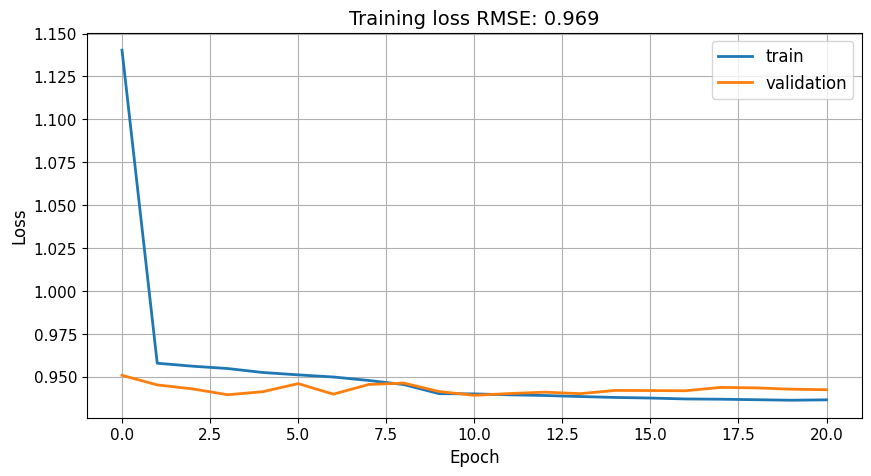

In [12]:
plt.figure(figsize = (10,5))
plt.plot(history.history['loss'], linewidth = 2)
plt.plot(history.history['val_loss'], linewidth = 2)
plt.title('Training loss RMSE: %.3f' %(rmse_dl), fontsize = 14)
plt.ylabel('Loss', fontsize = 12)
plt.xlabel('Epoch', fontsize = 12)
plt.legend(['train', 'validation'], loc='upper right', fontsize = 12)
plt.grid()
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

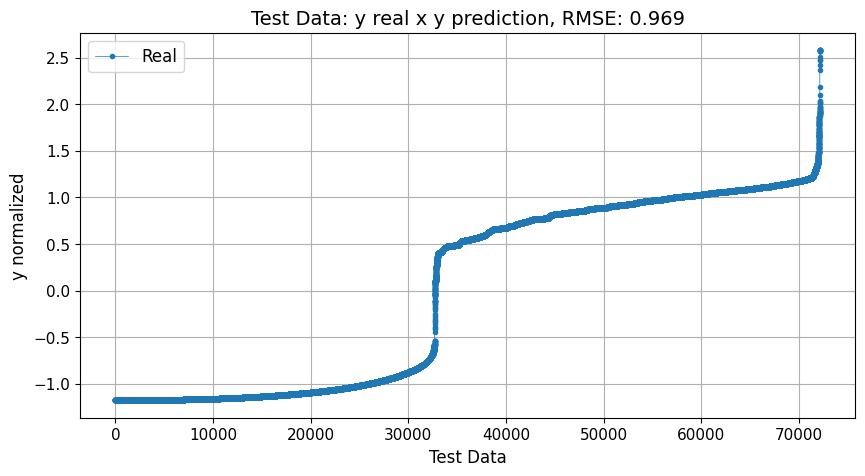

In [17]:
prediction_results = np.asarray(np.column_stack((y_test_scaled, y_test_pred_scaled)))
prediction_results = sorted(prediction_results, key= lambda x: x[0])
prediction_results = np.asarray(prediction_results)
plt.figure(figsize = (10,5))
plt.plot(np.asarray(np.asarray(prediction_results[:,0])), 
         linestyle='-', linewidth=0.5, marker='o', markersize=3, label = 'Real')
# plt.plot(np.asarray(np.asarray(prediction_results[:,1])), 
#          linestyle='-', linewidth=0.5, marker='^', markersize=3, label = 'Prediction')
plt.title('Test Data: y real x y prediction, RMSE: %.3f'
          %(rmse_dl), fontsize = 14)
plt.xlabel('Test Data', fontsize = 12)
plt.ylabel('y normalized', fontsize = 12)
plt.legend(fontsize = 12)
plt.grid()
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

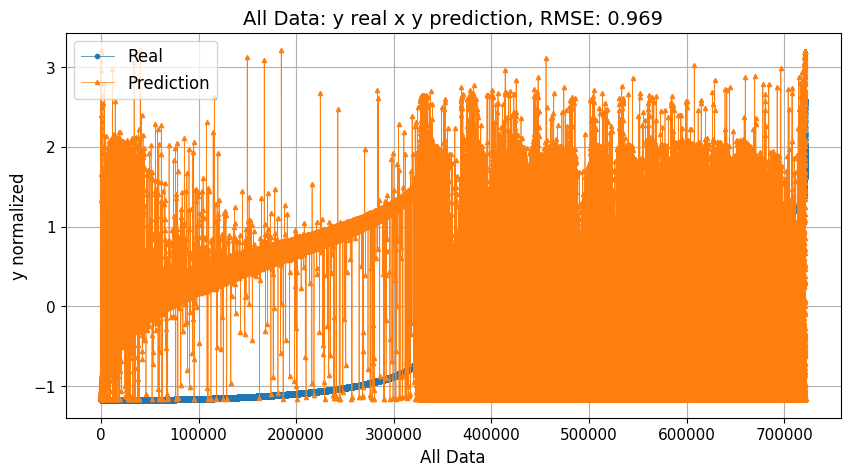

In [14]:
prediction_results = np.asarray(np.column_stack((y_scaled, y_pred_scaled)))
prediction_results = sorted(prediction_results, key= lambda x: x[0])
prediction_results = np.asarray(prediction_results)
plt.figure(figsize = (10,5))
plt.plot(np.asarray(np.asarray(prediction_results[:,0])), 
         linestyle='-', linewidth=0.5, marker='o', markersize=3, label = 'Real')
plt.plot(np.asarray(np.asarray(prediction_results[:,1])), 
         linestyle='-', linewidth=0.5, marker='^', markersize=3, label = 'Prediction')
plt.title('All Data: y real x y prediction, RMSE: %.3f'
          %(rmse_dl), fontsize = 14)
plt.xlabel('All Data', fontsize = 12)
plt.ylabel('y normalized', fontsize = 12)
plt.legend(fontsize = 12)
plt.grid()
plt.xticks(fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

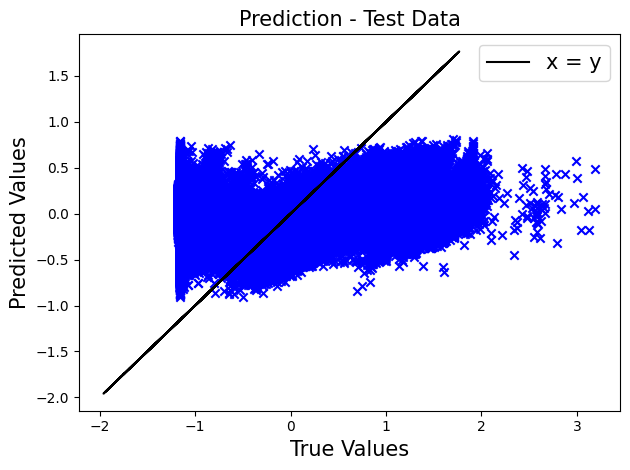

In [ ]:
# Predicted vs True values - Test Data
plt.figure()
reta = np.random.uniform(low=-2, high=2, size=(50,))
plt.plot(reta,reta, color='black', label='x = y') #plot reta x = y
plt.scatter(y_test_scaled, y_test_pred_scaled, color='blue', marker='x')
plt.legend(fontsize=15, loc='best')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predicted Values', fontsize=15)
plt.title('Prediction - Test Data', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/model_{MODEL_ID}_test_predictions.png')
plt.show()
plt.close()

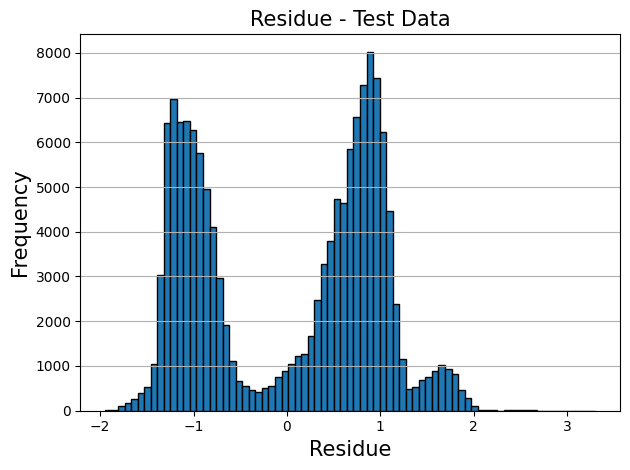

In [ ]:
# Residue - Test Data
plt.figure()
plt.grid(axis='y')
plt.hist(x=residue_test, bins='auto', ec='black')
plt.ylabel('Frequency', fontsize=15)
plt.xlabel('Residue', fontsize=15)
plt.title('Residue - Test Data', fontsize=15)
plt.tight_layout()
plt.savefig(f'{FIGURES_FOLDER}/model_{MODEL_ID}_test_residue.png')
plt.show()
plt.close()